# Kennedy and O'Hagan (KOH) Calibration with MVNormal (No pymc.gp)

이 노트북은 pymc.gp를 사용하지 않고, 공분산 행렬을 직접 구성하여 pm.MvNormal로 주변화된 KOH 프레임워크를 구현합니다.

- 시뮬레이터 에뮬레이터 η(x, θ): RBF(ARD) 커널
- 모델 불일치 δ(x): RBF(ARD) 커널
- 관측 모델: [y_c, z_f] ~ MVN(0, Σ)
- Σ는 K_eta, K_delta, 관측노이즈를 이용해 블록 공분산으로 구성됩니다.



## 개요 및 모델 식

KOH 모델:

- z(x) = ρ · η(x, θ) + δ(x) + ε_f
- y_c(x, t) = η(x, t) + ε_c

공분산(0-mean 가정):
- K_cc = K_eta([Xc,Tc],[Xc,Tc]) + σ_c² I
- K_ff = ρ² K_eta([Xf,θ],[Xf,θ]) + K_delta(Xf,Xf) + σ_f² I
- K_cf = ρ K_eta([Xc,Tc],[Xf,θ])
- Σ = [[K_cc, K_cf],[K_cfᵀ, K_ff]]



In [1]:
# 라이브러리 임포트
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import pytensor
import pytensor.tensor as pt

pytensor.config.compute_test_value = "ignore"



In [2]:
# 데이터 로드
DF_C_PATH = "../dataset/datacomp_hourly.csv"
DF_F_PATH = "../dataset/datafield_hourly.csv"

df_c = pd.read_csv(DF_C_PATH)
df_f = pd.read_csv(DF_F_PATH)

print("df_c:", df_c.shape, df_c.columns.tolist())
print("df_f:", df_f.shape, df_f.columns.tolist())


df_c: (240, 6) ['yc', 'xc1', 'xc2', 'tc1', 'tc2', 'tc3']
df_f: (24, 3) ['yf', 'xf1', 'xf2']


In [3]:
# 정규화 (Min-Max) — 기존 예제와 동일 규칙
# 시뮬레이션 출력(y) 스케일을 기준으로 관측 z_f도 동일 스케일 적용

# 시뮬레이션 출력
y_c_raw = df_c.iloc[:, 0].to_numpy()
y_min = float(y_c_raw.min())
y_max = float(y_c_raw.max())
y_c = (y_c_raw - y_min) / (y_max - y_min)

# 시뮬레이션 입력 x_c (x1,x2)
x_c_raw = df_c.iloc[:, 1:3].to_numpy()
x_min = x_c_raw.min(axis=0)
x_max = x_c_raw.max(axis=0)
x_c = (x_c_raw - x_min) / (x_max - x_min)

# 시뮬레이션 파라미터 t_c (theta1..3)
t_c_raw = df_c.iloc[:, 3:].to_numpy()
t_min = t_c_raw.min(axis=0)
t_max = t_c_raw.max(axis=0)
t_c = (t_c_raw - t_min) / (t_max - t_min)

# 관측 z_f 와 x_f
z_f_raw = df_f.iloc[:, 0].to_numpy()
z_f = (z_f_raw - y_min) / (y_max - y_min)  # y 스케일과 동일 적용
x_f_raw = df_f.iloc[:, 1:3].to_numpy()
x_f = (x_f_raw - x_min) / (x_max - x_min)

norm_stats = {
    "y_min": y_min, "y_max": y_max,
    "x_min": x_min, "x_max": x_max,
    "t_min": t_min, "t_max": t_max,
}

print("y_c ∈ [", y_c.min(), y_c.max(), "]  (normalized)")
print("x_c range normalized to [0,1] per dim:", x_min, x_max)
print("t_c range normalized to [0,1] per dim:", t_min, t_max)
print("z_f normalized with same y scale")


y_c ∈ [ 0.0 1.0 ]  (normalized)
x_c range normalized to [0,1] per dim: [23.82 70.58] [28.35 89.42]
t_c range normalized to [0,1] per dim: [6.63 5.37 2.43] [9.34 7.65 3.45]
z_f normalized with same y scale


In [4]:
# PyTensor 기반 RBF(ARD) 커널 구현

def rbf_cov(X: pt.matrix, Z: pt.matrix, lengthscales: pt.vector, amplitude: pt.scalar) -> pt.matrix:
    """RBF with ARD: k(x,z) = α^2 exp(-0.5 * sum_j ((x_j - z_j)^2 / ℓ_j^2))
    X: (n,d), Z: (m,d), lengthscales: (d,), amplitude: scalar
    """
    X_scaled = X / lengthscales
    Z_scaled = Z / lengthscales
    X_sq = pt.sum(X_scaled**2, axis=1, keepdims=True)        # (n,1)
    Z_sq = pt.sum(Z_scaled**2, axis=1, keepdims=True).T      # (1,m)
    sqdist = X_sq + Z_sq - 2.0 * (X_scaled @ Z_scaled.T)     # (n,m)
    return (amplitude**2) * pt.exp(-0.5 * sqdist)

# 도움 함수: numpy→pt 상수 변환

def as_pt_matrix(a: np.ndarray) -> pt.matrix:
    return pt.as_tensor_variable(a.astype(np.float64))



In [5]:
# 블록 공분산 Σ 구성 함수

def build_joint_cov(
    Xc: pt.matrix, Tc: pt.matrix, Xf: pt.matrix, theta: pt.vector,
    rho: pt.scalar,
    ell_eta: pt.vector, alpha_eta: pt.scalar,
    ell_delta: pt.vector, alpha_delta: pt.scalar,
    sigma_c: pt.scalar, sigma_f: pt.scalar,
):
    """
    Return Σ = [[K_cc, K_cf],[K_fc, K_ff]]
    - K_eta on 5D: [x1,x2,theta1,theta2,theta3]
    - K_delta on 2D: [x1,x2]
    """
    n_c = Xc.shape[0]
    n_f = Xf.shape[0]

    # 5D 입력 구성
    Xc5 = pt.concatenate([Xc, Tc], axis=1)  # (n_c,5)
    theta_tiled = pt.tile(theta, (n_f,))
    theta_mat = theta.reshape((1, theta.shape[0]))
    theta_mat = pt.repeat(theta_mat, n_f, axis=0)            # (n_f,3)
    Xf5 = pt.concatenate([Xf, theta_mat], axis=1)            # (n_f,5)

    # η 커널 블록
    Kcc_eta = rbf_cov(Xc5, Xc5, ell_eta, alpha_eta)
    Kff_eta = rbf_cov(Xf5, Xf5, ell_eta, alpha_eta)
    Kcf_eta = rbf_cov(Xc5, Xf5, ell_eta, alpha_eta)

    # δ 커널 블록 (2D)
    Kff_delta = rbf_cov(Xf, Xf, ell_delta, alpha_delta)

    # 노이즈 추가
    I_c = pt.eye(n_c)
    I_f = pt.eye(n_f)

    K_cc = Kcc_eta + (sigma_c**2) * I_c
    K_ff = (rho**2) * Kff_eta + Kff_delta + (sigma_f**2) * I_f
    K_cf = rho * Kcf_eta

    # Joint Σ
    top = pt.concatenate([K_cc, K_cf], axis=1)
    bottom = pt.concatenate([K_cf.T, K_ff], axis=1)
    Sigma = pt.concatenate([top, bottom], axis=0)

    return Sigma

# 상수 텐서 준비 (데이터 부분)
Xc_pt = as_pt_matrix(x_c)
Tc_pt = as_pt_matrix(t_c)
Xf_pt = as_pt_matrix(x_f)
y_c_pt = as_pt_matrix(y_c[:, None])
z_f_pt = as_pt_matrix(z_f[:, None])
obs_concat = pt.concatenate([y_c_pt, z_f_pt], axis=0).flatten()  # (n_c + n_f,)
print("obs length:", obs_concat.eval().shape)



obs length: (264,)


In [6]:
# PyMC 모델 정의 (MVNormal 관찰)
with pm.Model() as koh_mv_model:
    # ρ
    rho = pm.Normal("rho", mu=0.0, sigma=1.0)

    # η 커널 파라미터 (5D)
    ell_eta = pm.HalfNormal("ell_eta", sigma=1.0, shape=5)
    alpha_eta = pm.HalfNormal("alpha_eta", sigma=1.0)

    # δ 커널 파라미터 (2D)
    ell_delta = pm.HalfNormal("ell_delta", sigma=1.0, shape=2)
    alpha_delta = pm.HalfNormal("alpha_delta", sigma=1.0)

    # 노이즈
    sigma_c = pm.HalfNormal("sigma_c", sigma=0.1)
    sigma_f = pm.HalfNormal("sigma_f", sigma=0.1)

    # 캘리브레이션 파라미터 θ ∈ [0,1]^3 (정규화 좌표)
    theta = pm.Uniform("theta", lower=0.0, upper=1.0, shape=3)

    # Joint covariance Σ
    Sigma = build_joint_cov(
        Xc=Xc_pt, Tc=Tc_pt, Xf=Xf_pt, theta=theta,
        rho=rho,
        ell_eta=ell_eta, alpha_eta=alpha_eta,
        ell_delta=ell_delta, alpha_delta=alpha_delta,
        sigma_c=sigma_c, sigma_f=sigma_f,
    )

    # MVN 관찰 (0-mean)
    pm.MvNormal("obs", mu=pt.zeros_like(obs_concat), cov=Sigma, observed=obs_concat)

print("모델 그래프 준비 완료")


모델 그래프 준비 완료


In [7]:
# 샘플링 및 요약
with koh_mv_model:
    idata = pm.sample(target_accept=0.9, chains=2, draws=1000, tune=1000, random_seed=42)

az.summary(idata, var_names=["rho","theta","ell_eta","alpha_eta","ell_delta","alpha_delta","sigma_c","sigma_f"])


/home/lsw91/Workspace/pymc-examples/.venv/lib/python3.11/site-packages/pymc/logprob/abstract.py:236: UserWarning: ValuedVar should not be present in the final graph!
  warnings.warn("ValuedVar should not be present in the final graph!")
/home/lsw91/Workspace/pymc-examples/.venv/lib/python3.11/site-packages/pymc/logprob/transform_value.py:44: UserWarning: TransformedValue should not be present in the final graph!
  warnings.warn("TransformedValue should not be present in the final graph!")
/home/lsw91/Workspace/pymc-examples/.venv/lib/python3.11/site-packages/pymc/logprob/transform_value.py:44: UserWarning: TransformedValue should not be present in the final graph!
  warnings.warn("TransformedValue should not be present in the final graph!")
/home/lsw91/Workspace/pymc-examples/.venv/lib/python3.11/site-packages/pymc/logprob/transform_value.py:44: UserWarning: TransformedValue should not be present in the final graph!
  warnings.warn("TransformedValue should not be present in the final g

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1282 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,0.994,0.005,0.985,1.004,0.000,0.000,785.0,788.0,1.0
theta[0],0.525,0.021,0.485,0.565,0.001,0.001,779.0,727.0,1.0
theta[1],0.450,0.007,0.437,0.464,0.000,0.000,832.0,705.0,1.0
theta[2],0.440,0.014,0.417,0.470,0.000,0.000,797.0,931.0,1.0
ell_eta[0],0.107,0.010,0.087,0.125,0.000,0.000,1750.0,1274.0,1.0
ell_eta[1],0.064,0.008,0.049,0.078,0.000,0.000,1684.0,1053.0,1.0
ell_eta[2],7.798,0.530,6.814,8.822,0.013,0.013,1771.0,1364.0,1.0
ell_eta[3],5.419,0.333,4.802,6.056,0.009,0.007,1469.0,1288.0,1.0
ell_eta[4],3.521,0.228,3.107,3.954,0.006,0.005,1382.0,1175.0,1.0
alpha_eta,0.418,0.031,0.365,0.477,0.001,0.001,1226.0,1179.0,1.0


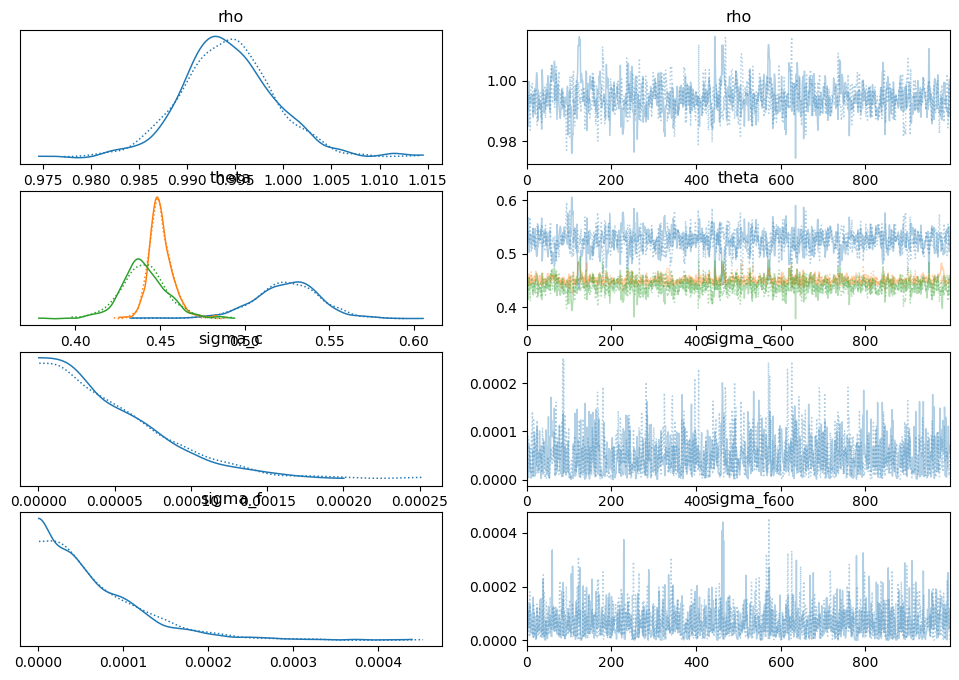

In [8]:
# 트레이스 플롯
with koh_mv_model:
    az.plot_trace(idata, var_names=["rho","theta","sigma_c","sigma_f"])


theta_true 파라미터 역변환 완료
정규화된 범위 [0, 1] → 물리적 단위로 변환
역변환에 사용된 최댓값 (theta_max): [9.34 7.65 3.45]

이제 파라미터를 물리적 단위로 해석 가능:
  - theta_true[0]: 기기밀도 (Equipment Density, 단위: W/m²)
  - theta_true[1]: 조명밀도 (Lighting Density, 단위: W/m²)
  - theta_true[2]: COP (Coefficient of Performance, 무차원)


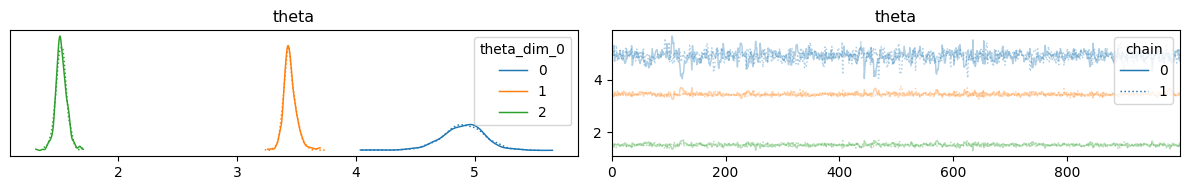

In [13]:

# =============================================================================
# theta_true 파라미터를 원래 물리적 단위로 역변환
# =============================================================================
# 목적: 정규화된 [0, 1] 범위의 파라미터를 원래 물리적 단위로 복원하여 해석 가능하게 만들기
#
# 역변환 공식: theta_true_original = theta_true_normalized × theta_max
#
# 차원 구조:
# - theta_max: (3,) - 3개 파라미터의 최댓값 [theta1_max, theta2_max, theta3_max]
# - theta_max[None, None, :]: (1, 1, 3) - 브로드캐스팅을 위한 차원 확장
# - trace.posterior.theta_true: (chain=1, draw=1000, parameter=3)
# - 결과: 모든 샘플에 대해 역변환이 적용됨

# Trace 복사 (원본 trace는 보존)
trace_ = idata.copy()

# 역변환 수행: 정규화된 파라미터에 최댓값을 곱하여 물리적 단위로 복원
# theta_max는 위 Cell 15에서 정규화 시 사용된 최댓값 벡터
trace_.posterior.theta.values *= t_max[None, None, :]

print("=" * 80)
print("theta_true 파라미터 역변환 완료")
print("=" * 80)
print("정규화된 범위 [0, 1] → 물리적 단위로 변환")
print(f"역변환에 사용된 최댓값 (theta_max): {t_max}")
print("\n이제 파라미터를 물리적 단위로 해석 가능:")
print("  - theta_true[0]: 기기밀도 (Equipment Density, 단위: W/m²)")
print("  - theta_true[1]: 조명밀도 (Lighting Density, 단위: W/m²)")
print("  - theta_true[2]: COP (Coefficient of Performance, 무차원)")
print("=" * 80)

# 역변환된 theta_true 값들의 사후 분포 시각화
# 물리적 단위로 해석 가능한 값들
az.plot_trace(trace_, legend=True, var_names=["theta"])
plt.tight_layout()
plt.show()

In [9]:
# 조건부 MVN 예측 (posterior mean 파라미터 사용, Xf 위치에서)
import numpy.linalg as npl

# numpy RBF (ARD)
def rbf_cov_np(X, Z, ell, alpha):
    Xs = X / ell
    Zs = Z / ell
    X_sq = np.sum(Xs**2, axis=1, keepdims=True)
    Z_sq = np.sum(Zs**2, axis=1, keepdims=True).T
    sqdist = X_sq + Z_sq - 2.0 * (Xs @ Zs.T)
    return (alpha**2) * np.exp(-0.5 * sqdist)

# posterior mean 파라미터 추출
post = idata.posterior
rho_m = float(post["rho"].mean())
ell_eta_m = np.array(post["ell_eta"].mean("chain","draw"))
alpha_eta_m = float(post["alpha_eta"].mean())
ell_delta_m = np.array(post["ell_delta"].mean("chain","draw"))
alpha_delta_m = float(post["alpha_delta"].mean())
sigma_c_m = float(post["sigma_c"].mean())
sigma_f_m = float(post["sigma_f"].mean())
theta_m = np.array(post["theta"].mean("chain","draw"))

# 공분산 블록 구성 (numpy)
Xc5 = np.concatenate([x_c, t_c], axis=1)
Xf5 = np.concatenate([x_f, np.repeat(theta_m[None,:], x_f.shape[0], axis=0)], axis=1)
Kcc_eta = rbf_cov_np(Xc5, Xc5, ell_eta_m, alpha_eta_m)
Kff_eta = rbf_cov_np(Xf5, Xf5, ell_eta_m, alpha_eta_m)
Kcf_eta = rbf_cov_np(Xc5, Xf5, ell_eta_m, alpha_eta_m)
Kff_delta = rbf_cov_np(x_f, x_f, ell_delta_m, alpha_delta_m)

K_cc = Kcc_eta + (sigma_c_m**2) * np.eye(x_c.shape[0])
K_ff = (rho_m**2) * Kff_eta + Kff_delta + (sigma_f_m**2) * np.eye(x_f.shape[0])
K_cf = rho_m * Kcf_eta

Sigma = np.block([[K_cc, K_cf], [K_cf.T, K_ff]])

y_obs = np.concatenate([y_c, z_f])

# Xf에서의 조건부 평균 (이미 일부가 관측되어 있으므로 self-consistency 확인 용)
# 여기서는 편의상 z_f의 예측 평균을 계산해 실제 z_f와 비교
n_c = x_c.shape[0]
K_yf = np.block([K_cf, K_ff])  # cov([y_c,z_f], z_f) = [K_cf; K_ff]
mu_cond = K_yf.T @ npl.solve(Sigma, y_obs)

# 역정규화하여 비교
z_pred = mu_cond * (norm_stats["y_max"] - norm_stats["y_min"]) + norm_stats["y_min"]
z_true = z_f * (norm_stats["y_max"] - norm_stats["y_min"]) + norm_stats["y_min"]

plt.figure(figsize=(5,5))
plt.scatter(z_true, z_pred, c="tab:blue")
lims = [min(z_true.min(), z_pred.min()), max(z_true.max(), z_pred.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("Observed z_f")
plt.ylabel("Predicted mean at Xf")
plt.title("Conditional mean check (field inputs)")
plt.grid(True, alpha=0.3)
plt.show()


TypeError: DataArrayAggregations.mean() takes from 1 to 2 positional arguments but 3 were given

## 해석 및 확장 포인트

- 본 노트북은 GP 모듈 없이 공분산을 직접 구성하여 `pm.MvNormal`로 주변화된 KOH를 구현했습니다.
- η와 δ에 대해 RBF(ARD)를 사용했지만, Matern, RationalQuadratic 등으로 교체 가능.
- 평균함수(상수/선형)를 추가해 바이어스 보정 가능.
- 조건부 예측은 현재 posterior mean 파라미터로만 시연했으나, 샘플별 평균을 집계하면 불확실성 대역도 표현 가능(계산량 증가).
- 입력/파라미터 정규화 설정은 반드시 일관되게 유지해야 하며, 역정규화 시 원 단위 해석을 병행하세요.

